<a href="https://colab.research.google.com/github/sushithadevaraju/sentiment-analysis-of-imdb/blob/main/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing file

In [1]:
from google.colab import files

uploaded = files.upload()


Saving IMDB Dataset.csv to IMDB Dataset.csv


Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


Load the Dataset

In [3]:
#Load the dataset
mov = pd.read_csv('IMDB Dataset.csv')

#Display the first few rows
print(mov.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Data preprocessing

In [4]:
#Download the punkt tokenizer
nltk.download('punkt')

#Checking for null values
print(mov.isnull().sum())

#preprocessing
def preprocess_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = ' '.join(text)
    return text

#Apply preprocessing to the dataset
mov['review'] = mov['review'].apply(preprocess_text)

#Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mov['review'], mov['sentiment'], test_size=0.2, random_state=42)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


review       0
sentiment    0
dtype: int64


Feature Extraction

In [5]:

#Create TF-IDF vectors for the text data
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()


In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
nltk.download('stopwords')
nltk.download('wordnet')

# Checking for null values
print(mov.isnull().sum())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


review       0
sentiment    0
dtype: int64


Preprocessing: Tokenization, Lemmatization, and Stemming

In [7]:
#Initializing tools for stemming and lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

#Preprocessing function
def preprocess_text(text):
    #Convert to lowercase
    text = text.lower()

    #Tokenization
    tokens = word_tokenize(text)

    #Removing stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    #Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #Stemming
    stemmed_tokens = [stemmer.stem(word) for word in lemmatized_tokens]

    #Joining tokens back into a string
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

#Apply preprocessing to the dataset
mov['review'] = mov['review'].apply(preprocess_text)

Model Implementation (Logistic Regression)


In [8]:
#Encode target labels
y_train = y_train.apply(lambda x: 1 if x == 'positive' else 0)
y_test = y_test.apply(lambda x: 1 if x == 'positive' else 0)

#Train Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

#Predicting the model
y_pred = lr_model.predict(X_test_tfidf)

#Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8938
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Model Implementation (LSTM)

In [9]:
#Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=200)
X_test_pad = pad_sequences(X_test_seq, maxlen=200)

#Defining LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

#Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 303s 480ms/step - accuracy: 0.7202 - loss: 0.5378 - val_accuracy: 0.8550 - val_loss: 0.3520
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 482ms/step - accuracy: 0.7517 - loss: 0.5064 - val_accuracy: 0.8791 - val_loss: 0.2943
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 296s 473ms/step - accuracy: 0.8911 - loss: 0.2696 - val_accuracy: 0.8916 - val_loss: 0.2622
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 322s 474ms/step - accuracy: 0.9165 - loss: 0.2142 - val_accuracy: 0.8945 - val_loss: 0.2610
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 320s 471ms/step - accuracy: 0.9310 - loss: 0.1819 - val_accuracy: 0.8964 - val_loss: 0.2706
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.8959 - loss: 0.2752
Test Accuracy: 0.896399974822998


Implementing Naive Bayes Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(mov['review'], mov['sentiment'], test_size=0.2, random_state=42)


In [11]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)


MultinomialNB()

In [12]:
#Training the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

#Make predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

#Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Accuracy: 0.852
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4961
    positive       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix:
 [[4234  727]
 [ 753 4286]]


Implementing SVM Model

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#Preprocessing (tokenization, lowercasing)
mov['review'] = mov['review'].str.lower()

#Splitng the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mov['review'], mov['sentiment'], test_size=0.2, random_state=42)
#Training the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

#Making predictions
y_pred = svm_model.predict(X_test_tfidf)

#Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8941
Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4961
    positive       0.89      0.90      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Confusion Matrix:
 [[4384  577]
 [ 482 4557]]


Visualization

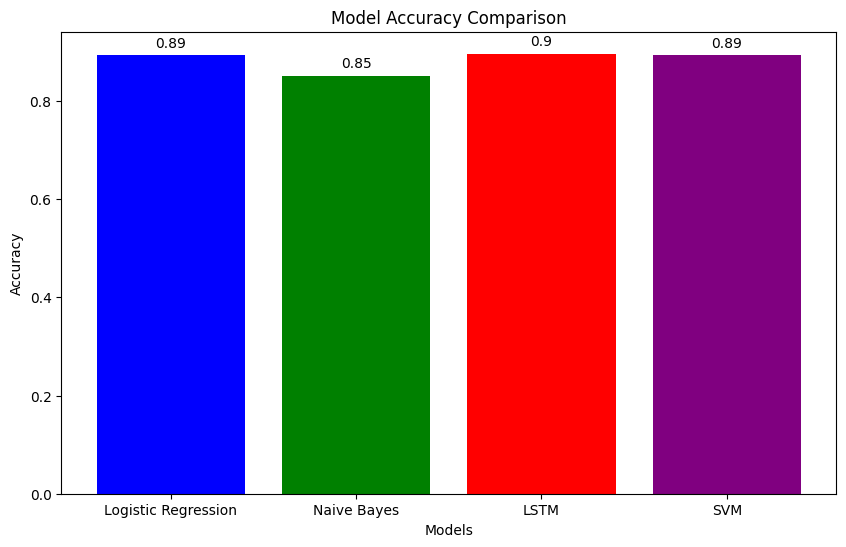

In [17]:
import matplotlib.pyplot as plt

#These are the accuracies obtained from the models
logistic_regression_accuracy = 0.8938
naive_bayes_accuracy = 0.852
lstm_accuracy = 0.896399974822998
svm_accuracy = 0.8941

#Creating a dictionary of model names and their corresponding accuracies
model_accuracies = {
    'Logistic Regression': logistic_regression_accuracy,
    'Naive Bayes': naive_bayes_accuracy,
    'LSTM': lstm_accuracy,
    'SVM': svm_accuracy

}

#Extracting the model names and accuracies for plotting
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

#Creating a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])

#Adding title and labels
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')

#Adding the accuracy values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

#Display's the plot
plt.show()


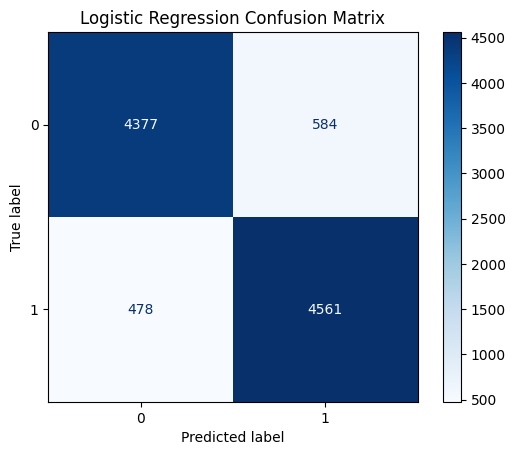

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predicting with Logistic Regression
y_pred_lr = lr_model.predict(X_test_tfidf)

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr_model.classes_)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix")
plt.show()
